In [34]:
import sqlite3
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from pandas.core.groupby.generic import DataFrameGroupBy
import re
from fpl.pipelines.model_pipeline.preprocessing.elo_calculation import calculate_elo_score
import matplotlib.pyplot as plt
import pickle
import yaml
%matplotlib inline

In [15]:
def read_df_from_db(table_name):
    with sqlite3.connect("data/fpl.db") as conn:
        df = pd.read_sql(f"select * from {table_name}", conn)
    return df

def load_pickle(filepath):
    with open(filepath, 'rb') as file:
        obj = pickle.load(file)
    return obj

def read_yml(filepath):
    with open(filepath, 'r') as file:
        data = yaml.safe_load(file)
    return data


In [9]:
holdout_data = read_df_from_db("holdout_data")
train_data = read_df_from_db("train_val_data")

In [13]:
fitted_sklearn_pipeline = load_pickle("models/fitted_sklearn_pipeline.pkl")

In [18]:
parameters = read_yml("conf/base/parameters.yml")["model"]
categorical_features = parameters["categorical_features"]
numerical_features = parameters["numerical_features"]
target = parameters["target"]
baseline_columns = parameters["baseline_columns"]

X_train = train_data[numerical_features + categorical_features]
y_train = train_data[target]
X_train_preprocessed = fitted_sklearn_pipeline.transform(X_train)
X_test = holdout_data[numerical_features + categorical_features]
X_test_preprocessed = fitted_sklearn_pipeline.transform(X_test)

In [22]:
import lightgbm

model = lightgbm.sklearn.LGBMRegressor()
model.fit(
    X=X_train_preprocessed,
    y=y_train,
    )
model

LGBMRegressor()

In [23]:
test_predictions = model.predict(X=X_test_preprocessed)
test_predictions

array([1.83858498, 0.99378551, 0.81536851, ..., 1.24802874, 0.1218303 ,
       1.48971938])

r2 = 0.14428148803588992
r2 = 0.17139079424273973
pred_r2 = 0.14428148803588992
mae = 1.4460646483143627
r2 = 0.14428148803588992


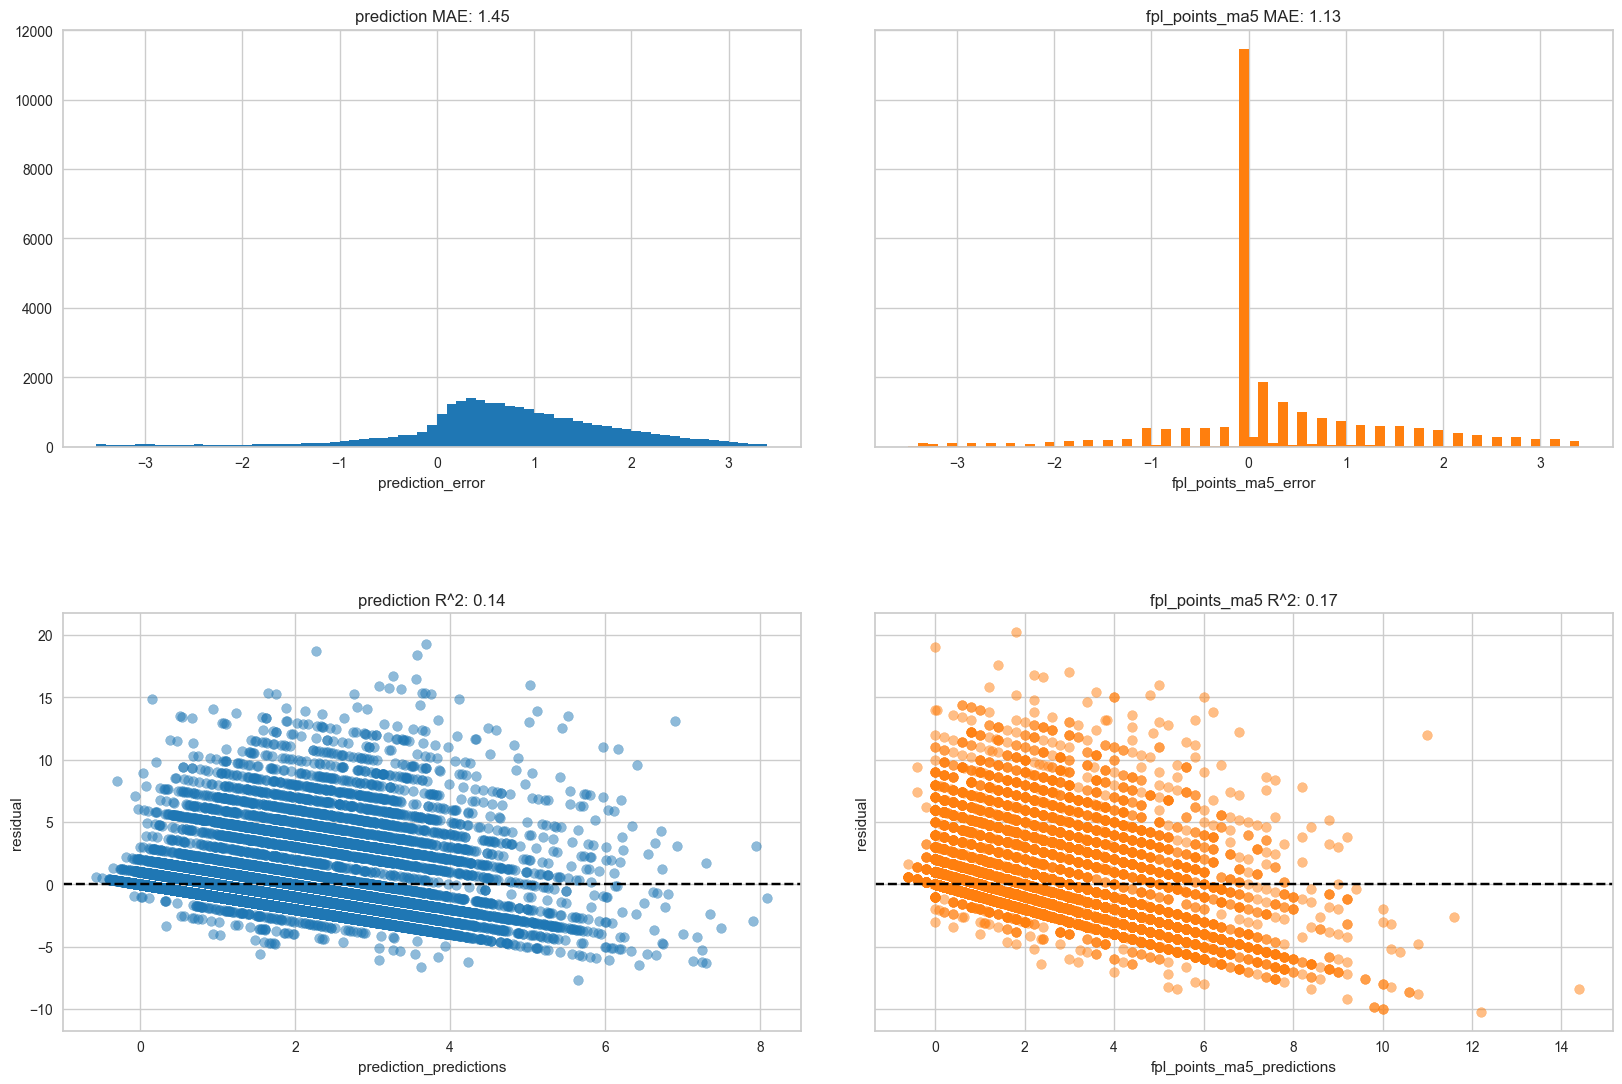

In [38]:
from fpl.pipelines.model_pipeline.modelling.evaluation import (
    ordered_set, 
    color_pal, 
    plot_residual_histogram, 
    # plot_residual_scatter,
    # calculate_r2
)
from sklearn.metrics import r2_score

def calculate_r2(target, prediction):
    not_nan = ~prediction.isna() & ~target.isna()
    target = target[not_nan]
    prediction = prediction[not_nan]
    return r2_score(target, prediction)

def plot_residual_scatter(
    ax,
    col: str,
    target: np.ndarray,
    prediction: np.ndarray,
    color: str = None,
) -> None:
    r2 = calculate_r2(target, prediction)
    print(f"{r2 = }")
    residual = target - prediction
    ax.scatter(prediction, residual, alpha=0.5, color=color)
    ax.axhline(0, color="black", linestyle="--")
    ax.set_xlabel(f"{col}_predictions")
    ax.set_ylabel(f"residual")
    ax.set_title(f"{col} R^2: {r2:.2f}")
    return None


output_cols = ordered_set(
    numerical_features + categorical_features + [target] + baseline_columns
)
output_df = holdout_data[output_cols].copy()
output_df["prediction"] = test_predictions

prediction_col = "prediction"
eval_cols = [prediction_col, "fpl_points_ma5"]
fig, axes = plt.subplots(
    nrows=2,
    ncols=len(eval_cols),
    figsize=(20, 13),
    sharey="row",
    gridspec_kw={"hspace": 0.4},
)

for i, col in enumerate(eval_cols):
    output_df[f"{col}_error"] = output_df[col] - output_df[target]
    plot_residual_histogram(
        ax=axes[0, i], col=col, errors=output_df[f"{col}_error"], color=color_pal[i]
    )
    plot_residual_scatter(
        ax=axes[1, i],
        col=col,
        target=output_df[target],
        prediction=output_df[col],
        color=color_pal[i],
    )

pred_mae = (output_df[f"{prediction_col}_error"]).abs().mean()
pred_r2 = calculate_r2(output_df[target], output_df[prediction_col])
print(f"{pred_r2 = }")

error_metrics = {
    f"mae": pred_mae,
    f"r2": pred_r2,
}
for metric, score in error_metrics.items():
    print(f"{metric} = {score}")
plt.subplots_adjust(wspace=0.1)
plt.show()

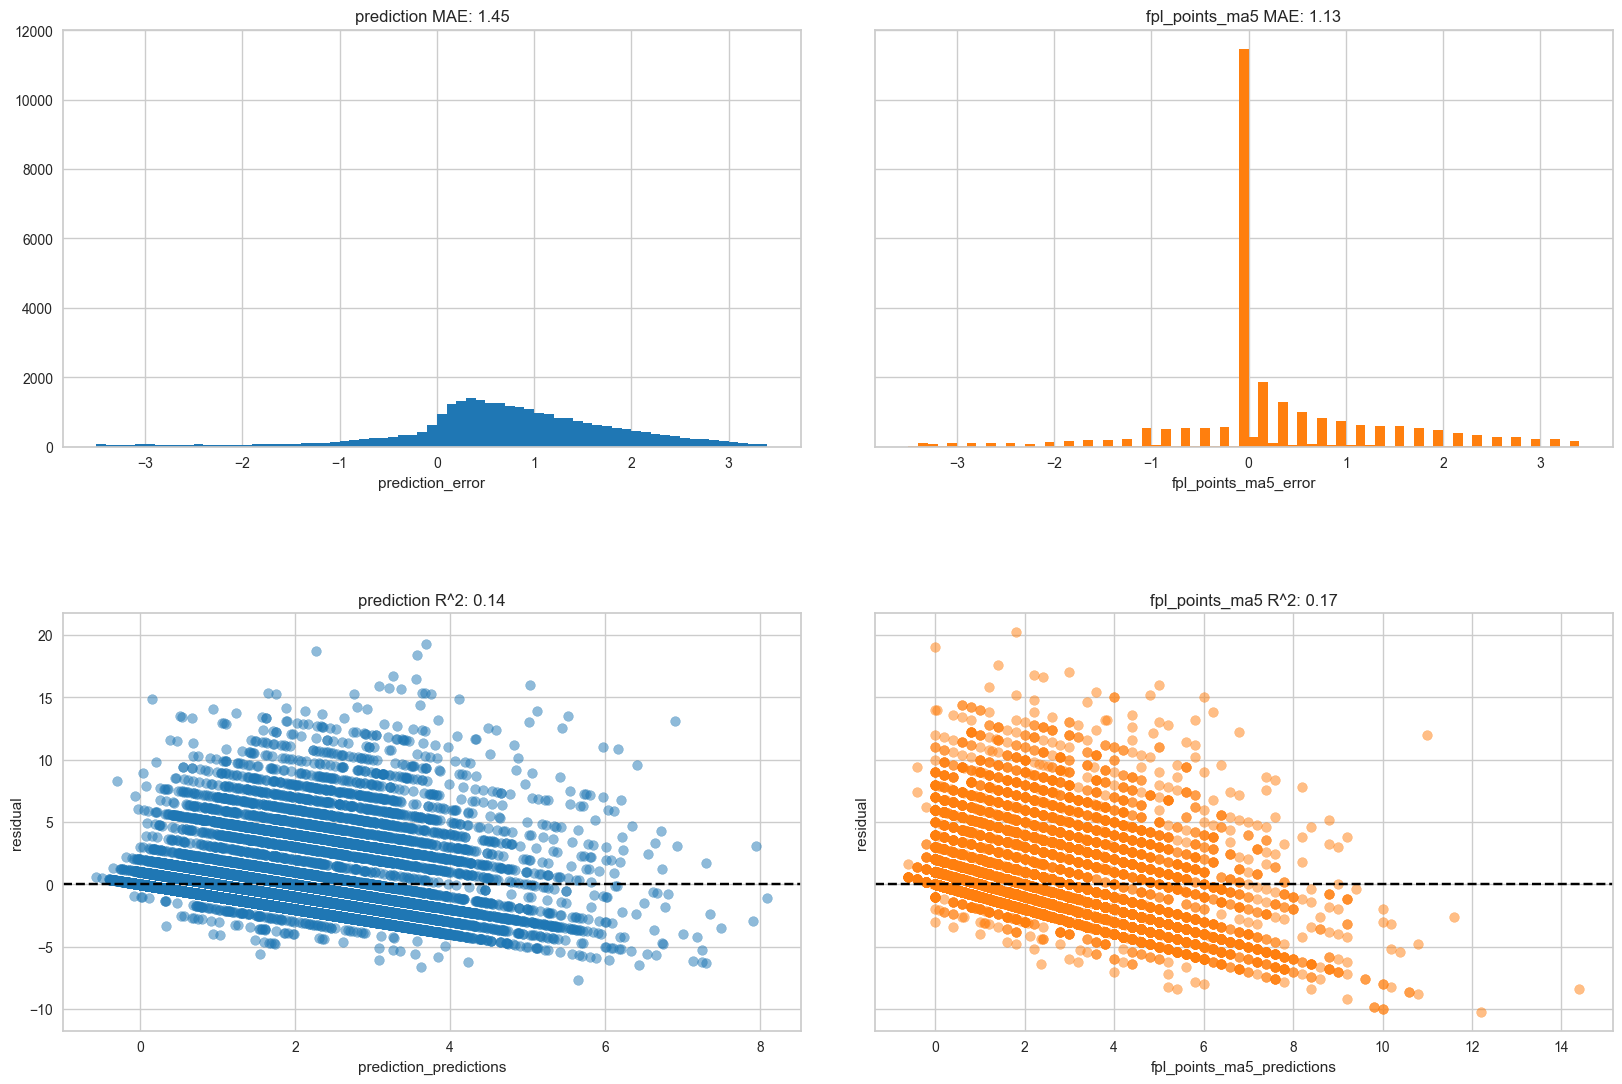

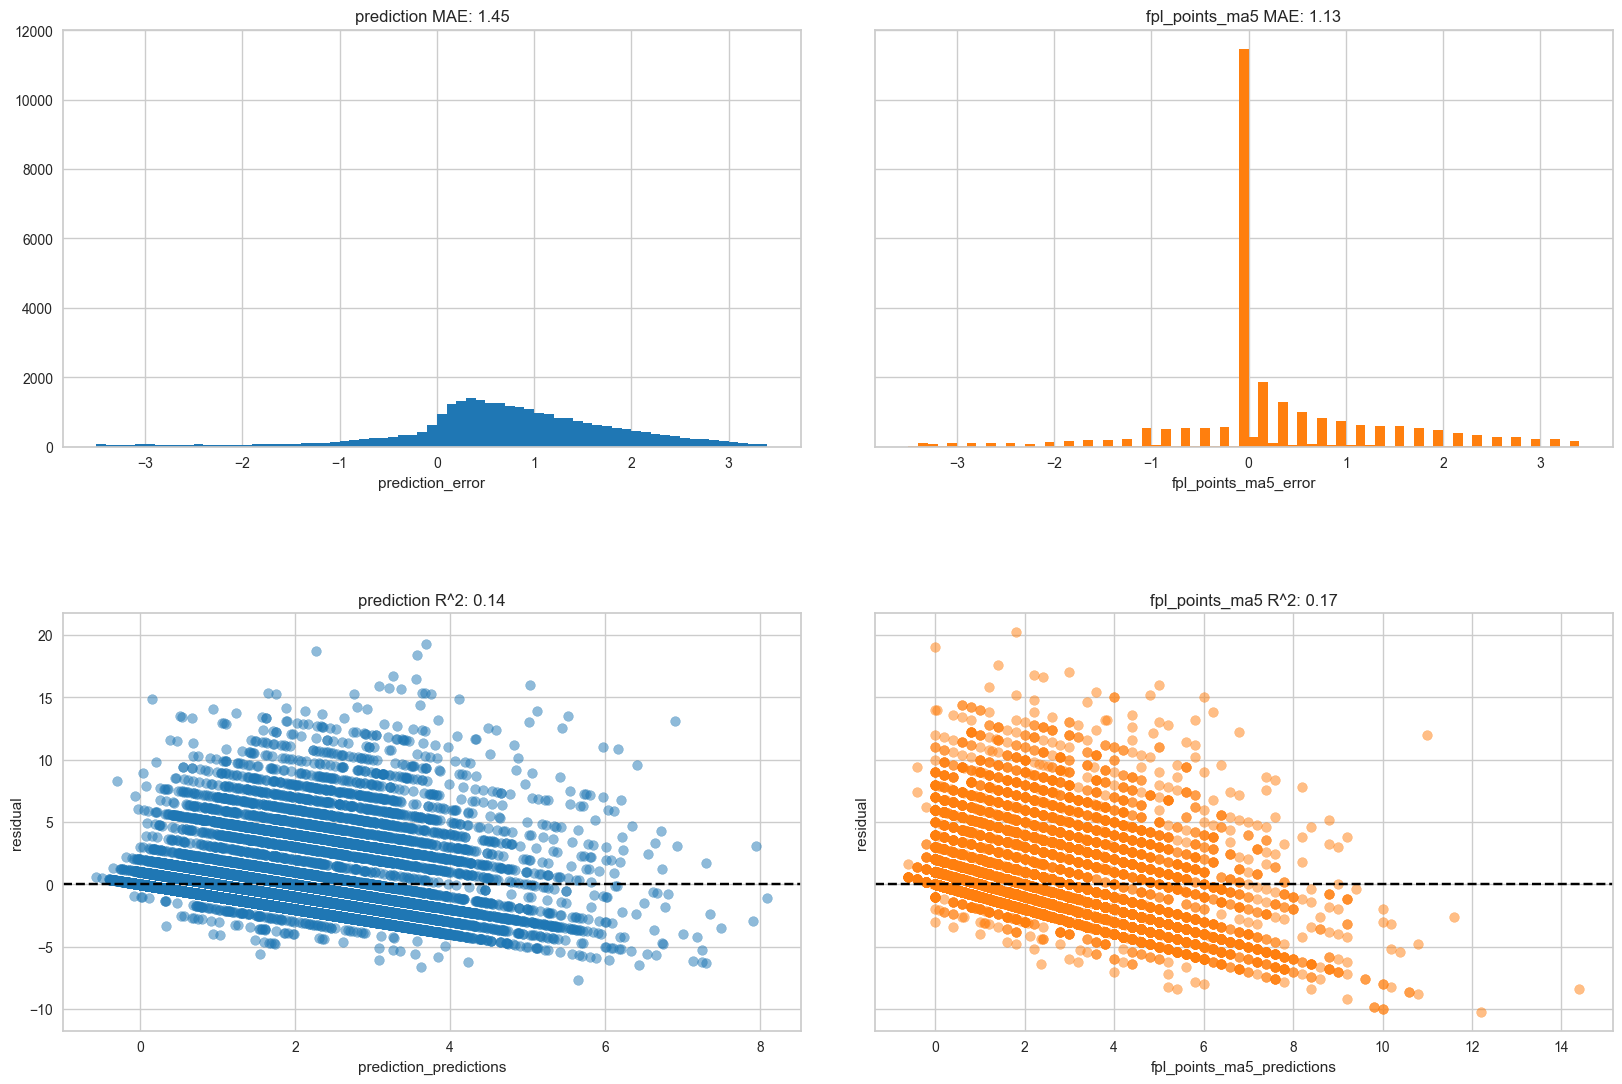

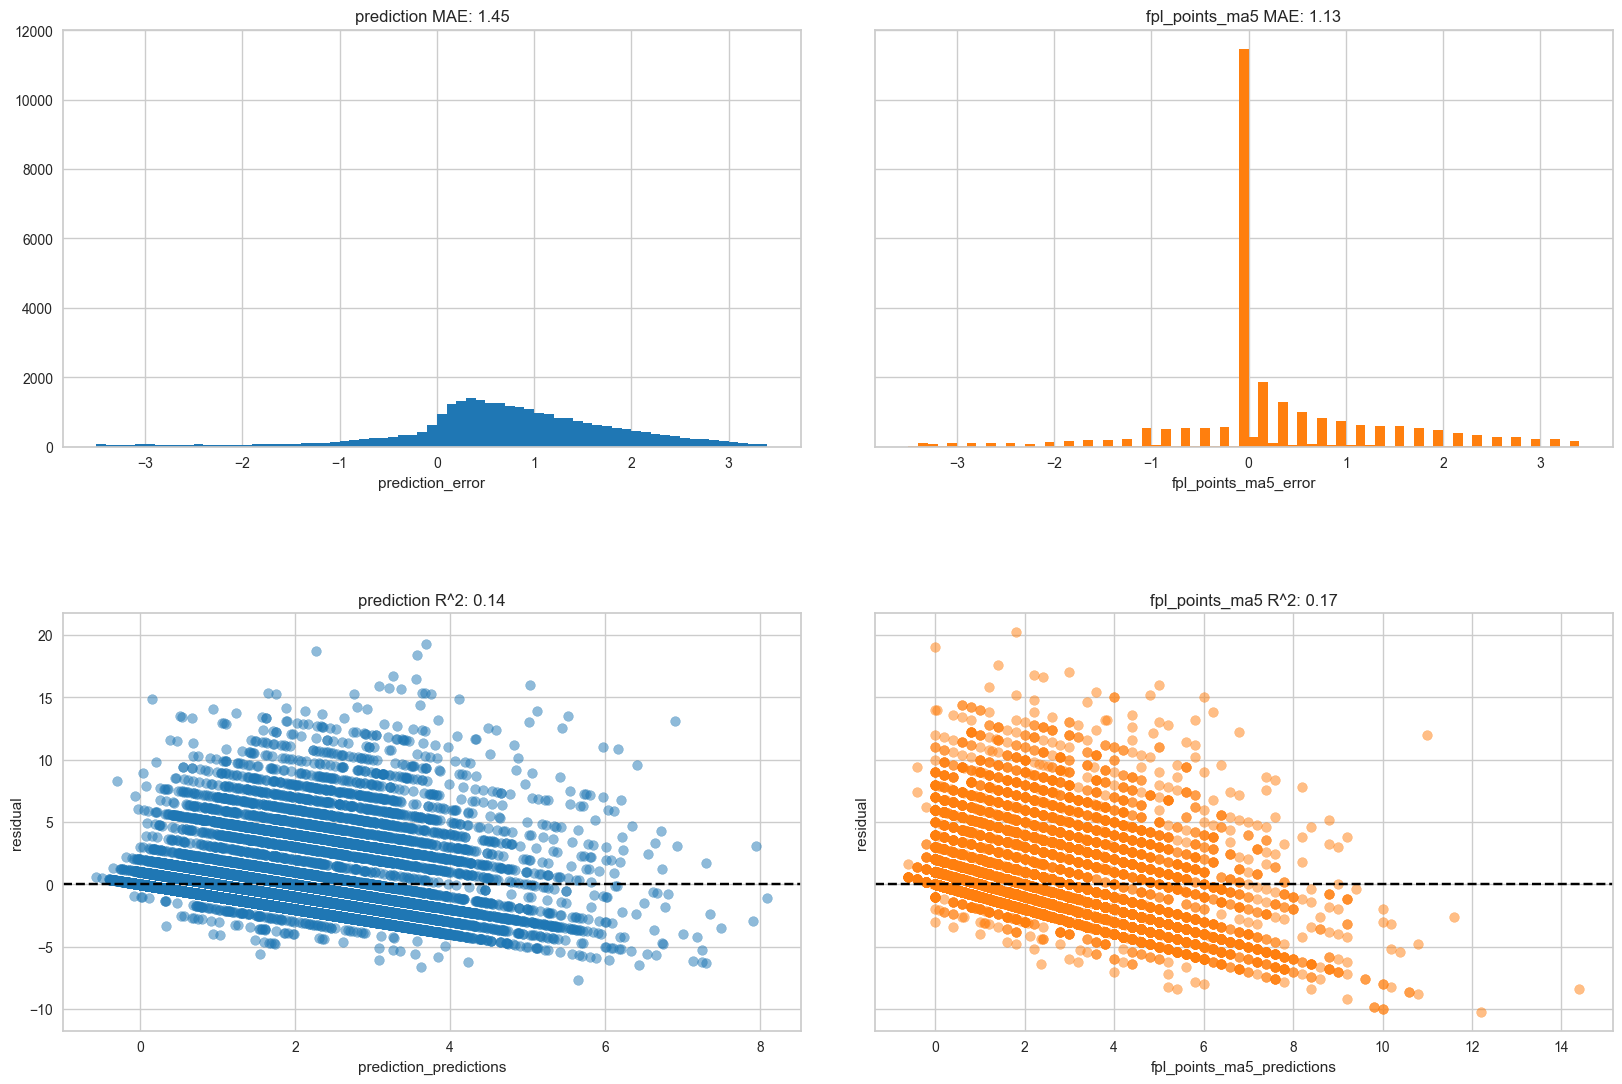

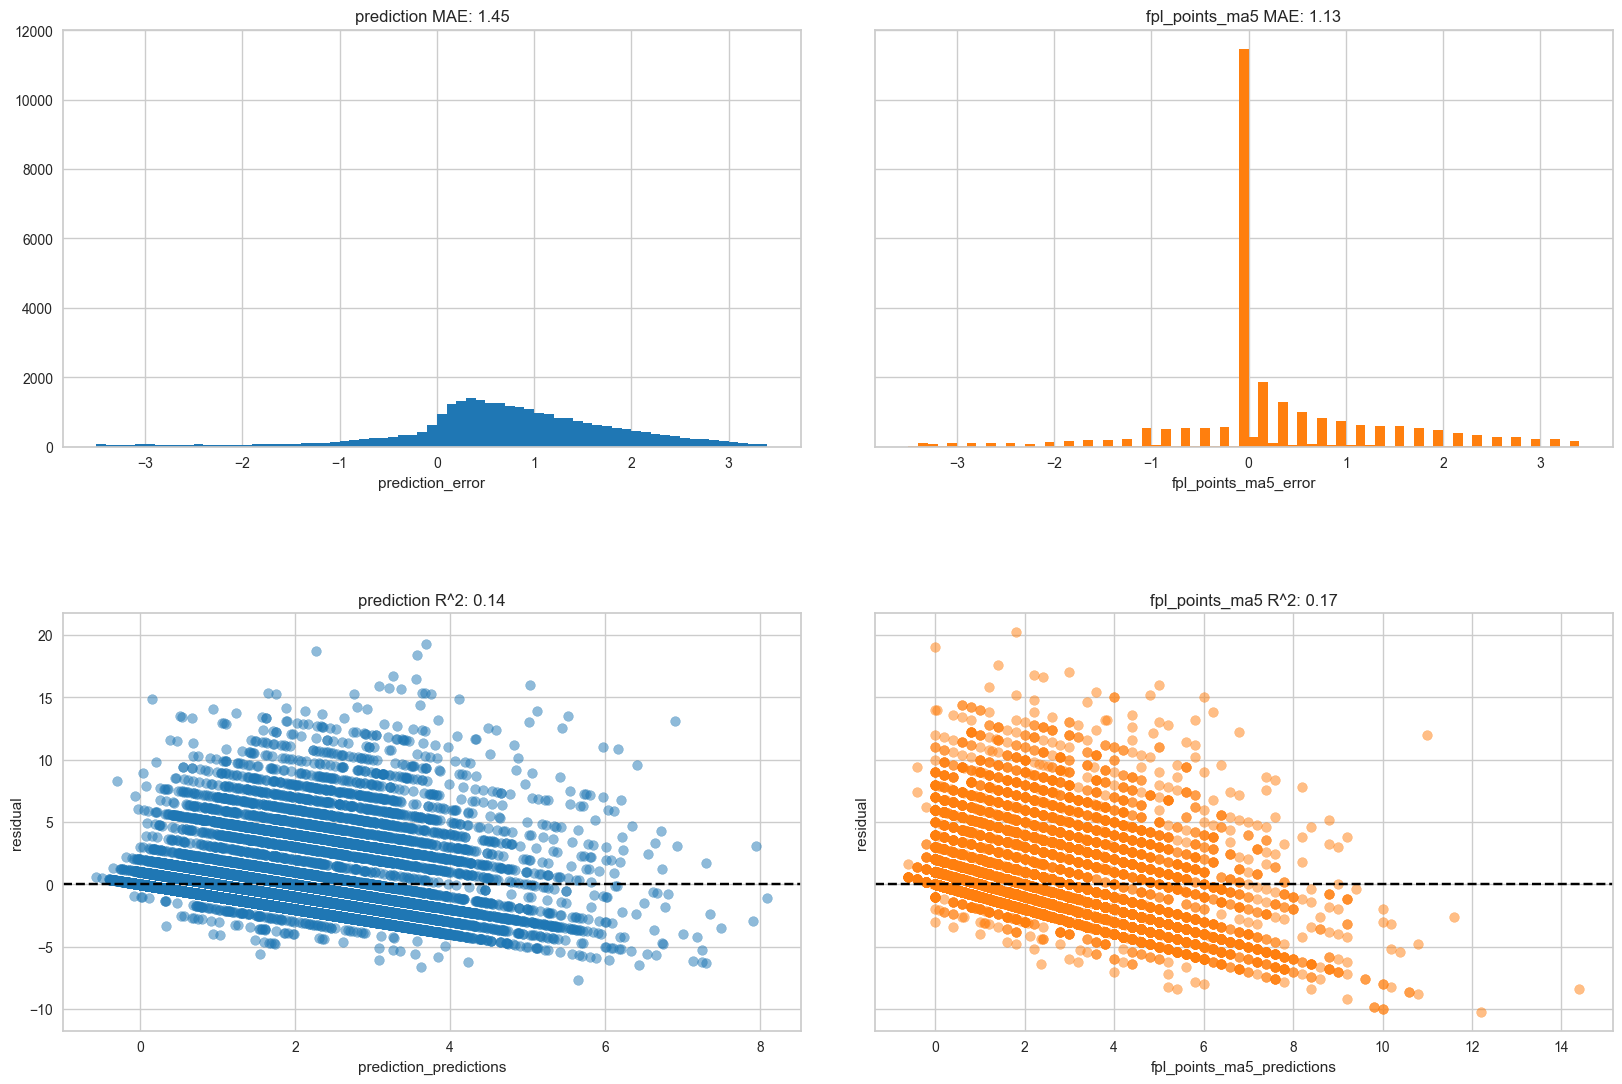

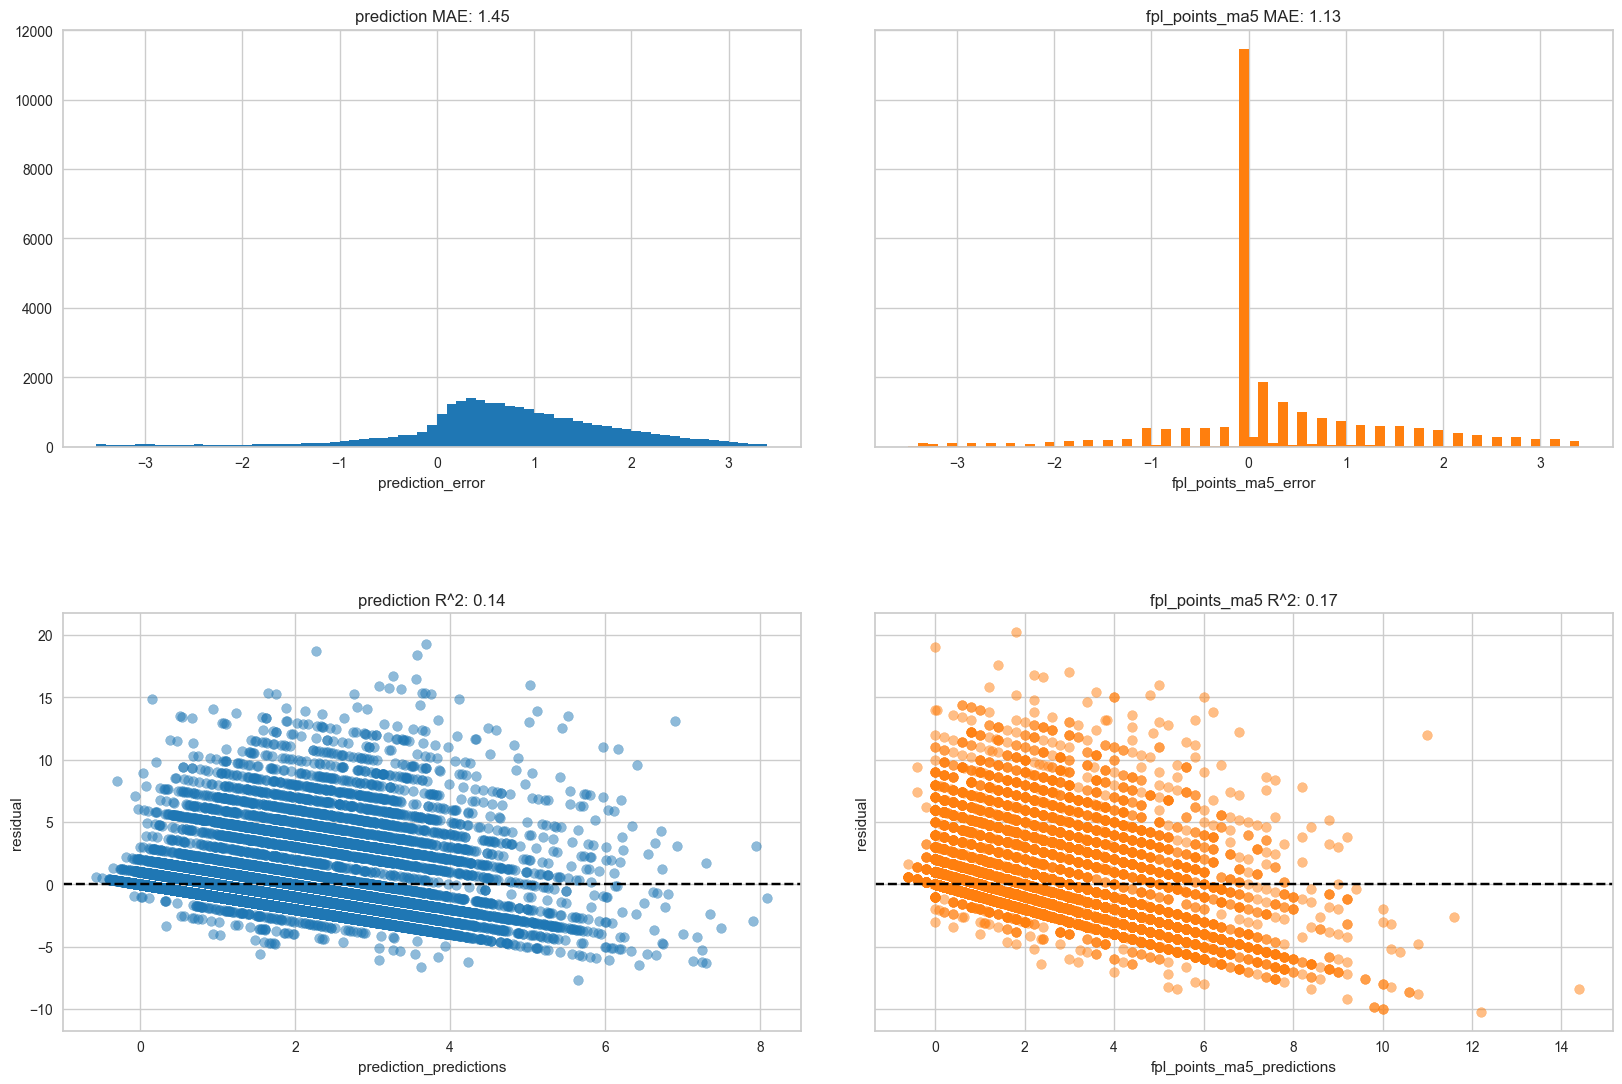

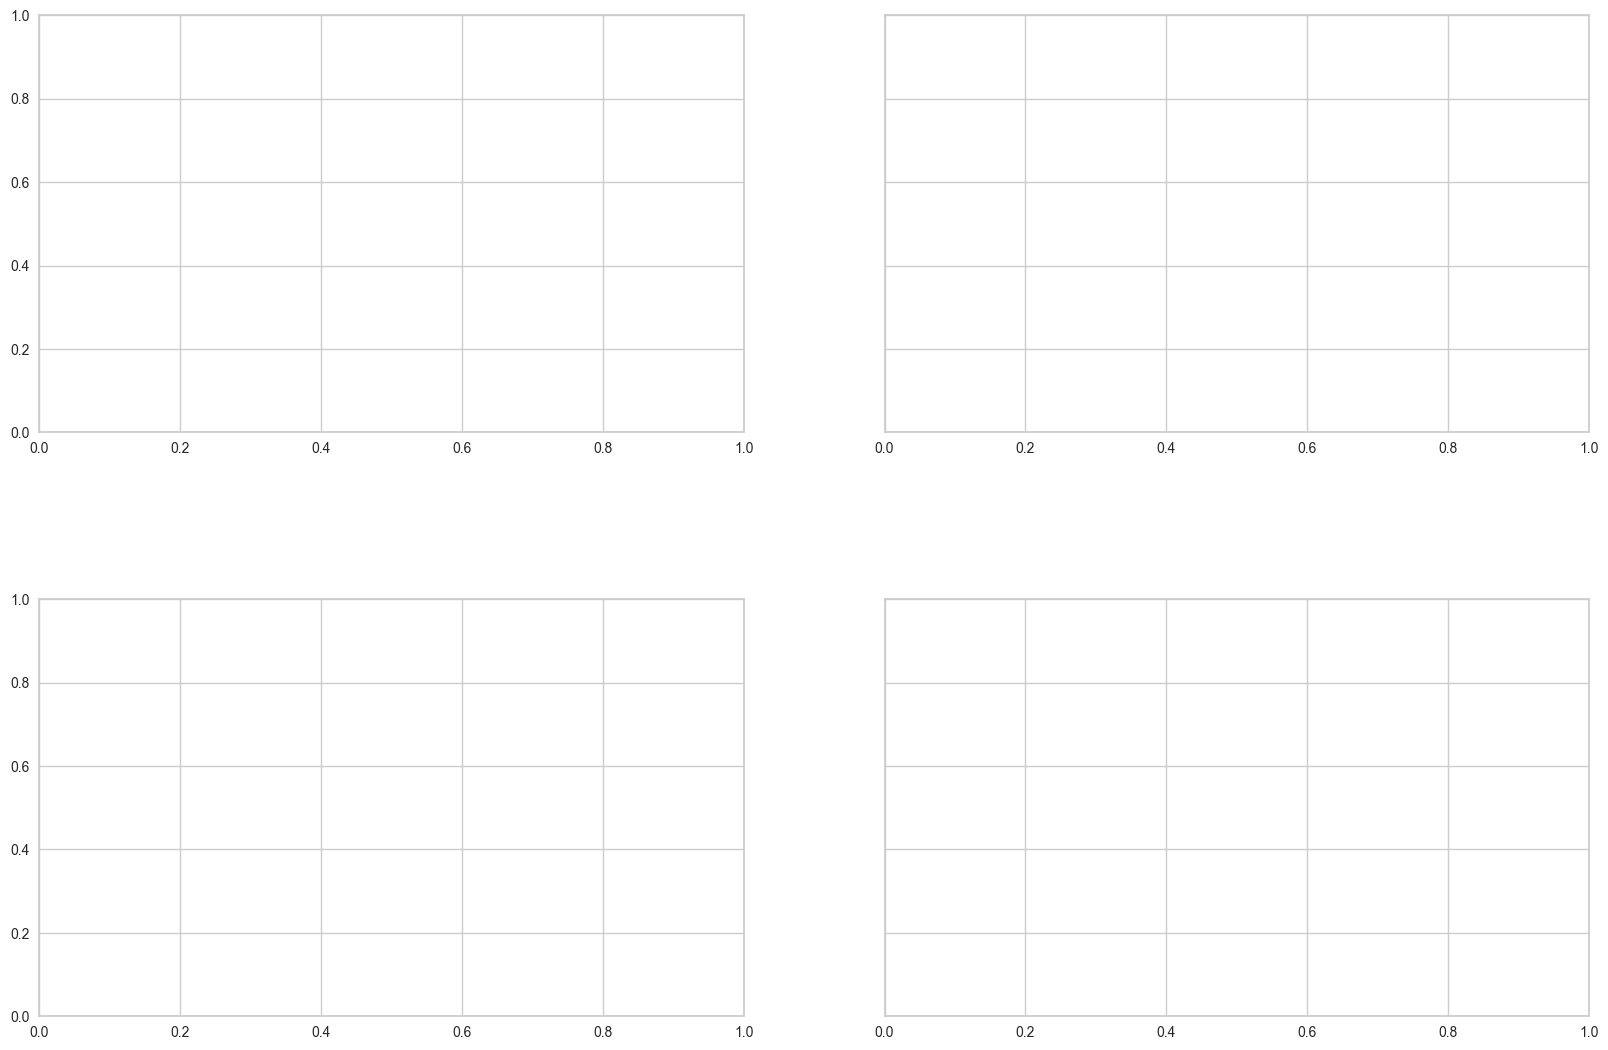

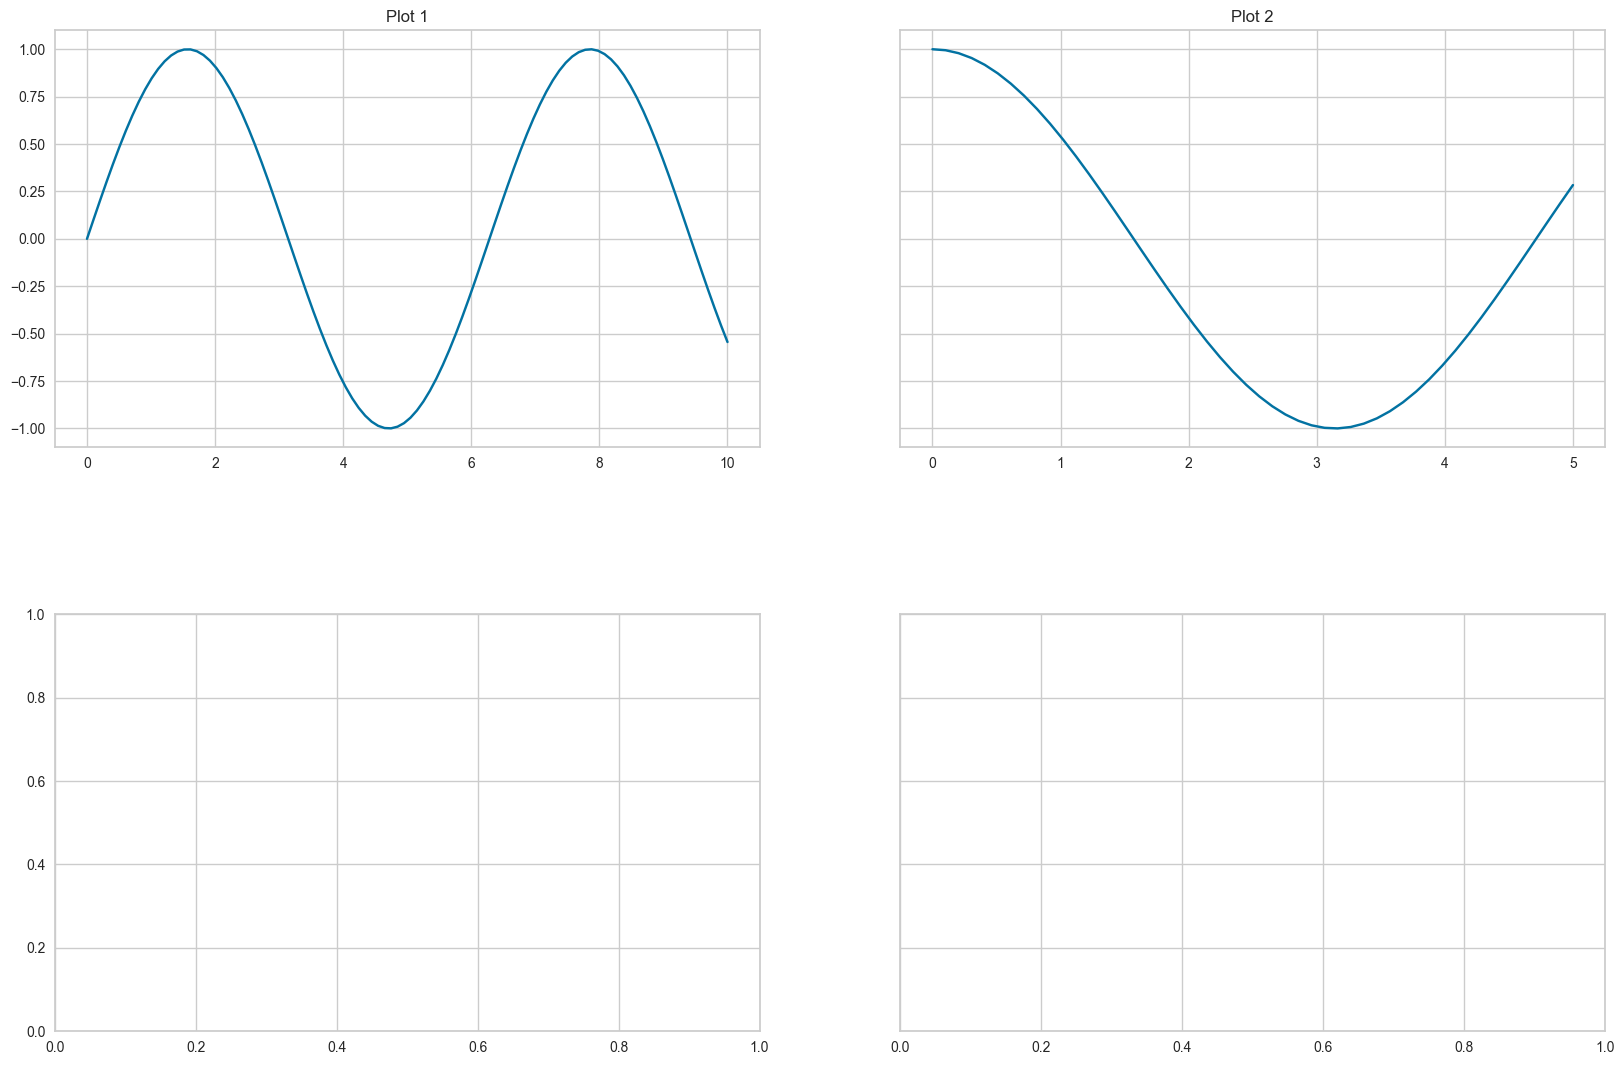

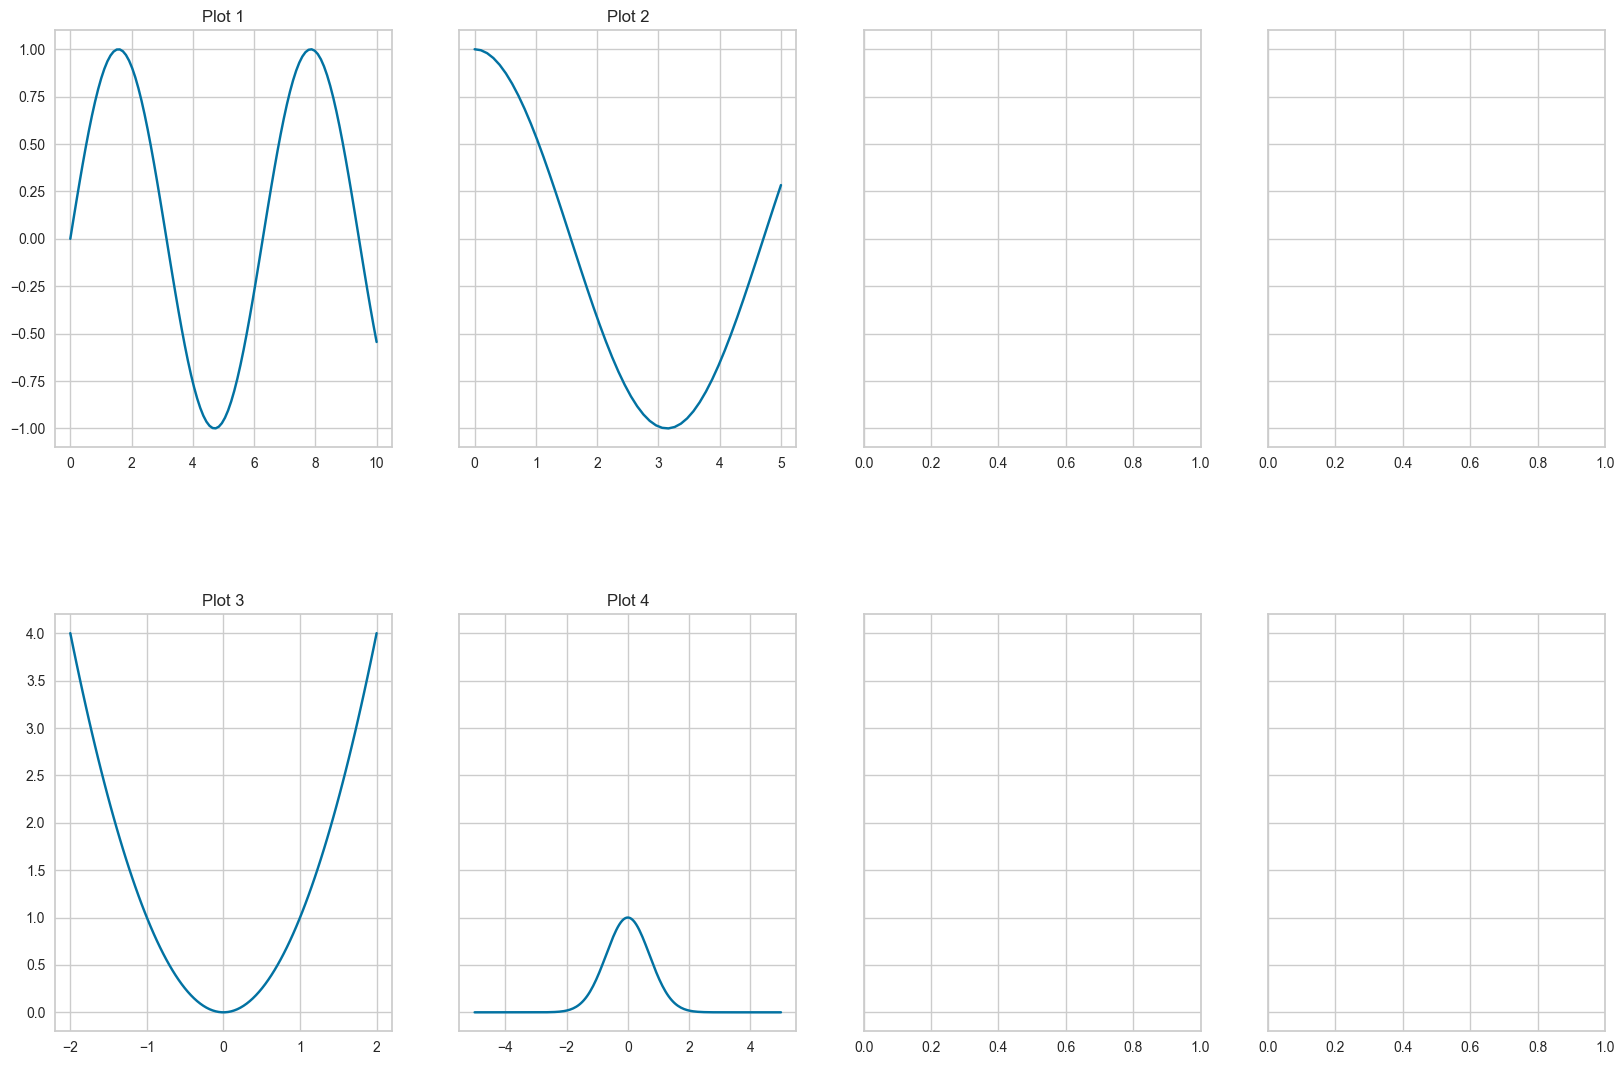

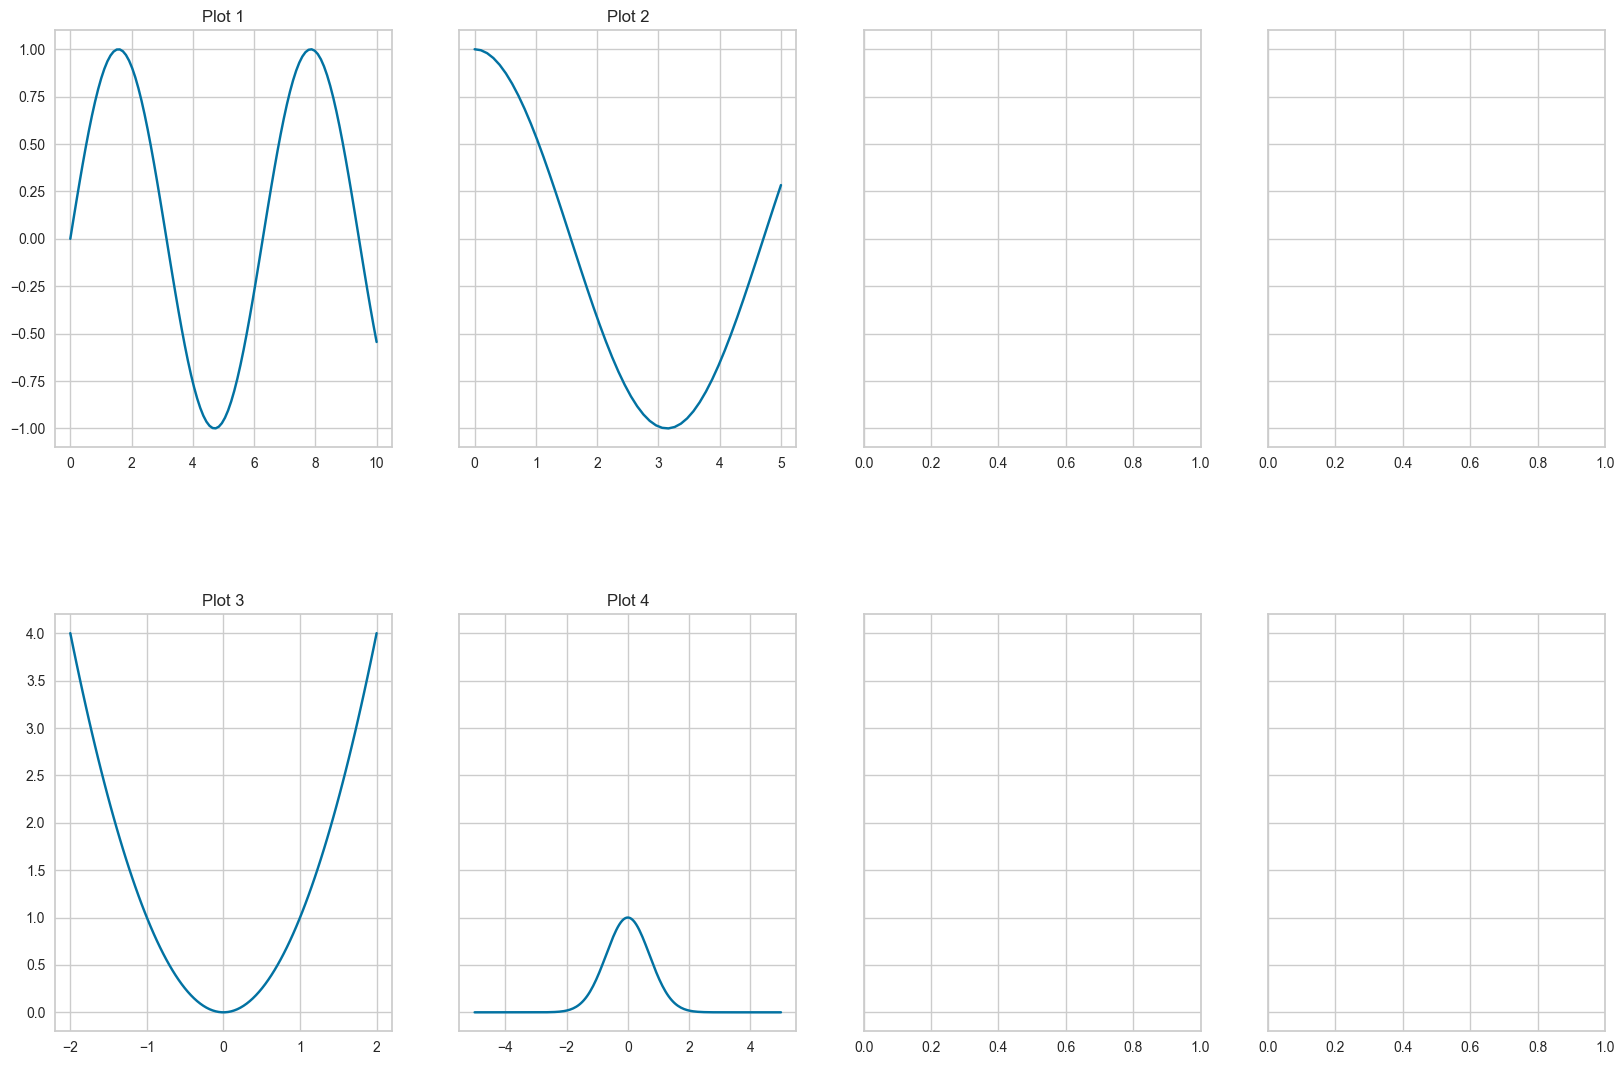

In [35]:
import matplotlib.pyplot as plt
import numpy as np

eval_cols = ['A', 'B', 'C', 'D']

fig, axes = plt.subplots(
    nrows=2,
    ncols=len(eval_cols),
    figsize=(20, 13),
    sharey="row",
    gridspec_kw={"hspace": 0.4},
)

# Plot 1
x1 = np.linspace(0, 10, 100)
y1 = np.sin(x1)
axes[0, 0].plot(x1, y1)
axes[0, 0].set_title('Plot 1')

# Plot 2
x2 = np.linspace(0, 5, 50)
y2 = np.cos(x2)
axes[0, 1].plot(x2, y2)
axes[0, 1].set_title('Plot 2')

# Plot 3
x3 = np.linspace(-2, 2, 100)
y3 = x3**2
axes[1, 0].plot(x3, y3)
axes[1, 0].set_title('Plot 3')

# Plot 4
x4 = np.linspace(-5, 5, 200)
y4 = np.exp(-x4**2)
axes[1, 1].plot(x4, y4)
axes[1, 1].set_title('Plot 4')

plt.show()